In [2]:
import sys
base_path = 'C:\\github\\aide-analysis'
sys.path.append(base_path)

from core.config import Config
config = Config()
config.RAWDATA_PATH

# 사전처리
from src.temp import *
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import glob
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore')

# DataFrame 디스플레이 설정
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
pd.set_option('display.width', 100)

# Pandas Float 자릿수 표시 제한
pd.options.display.float_format = '{:.2f}'.format

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline
# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

# KB부동산

### 1. 거래량과 미분양 정말로 관계가 없을까?

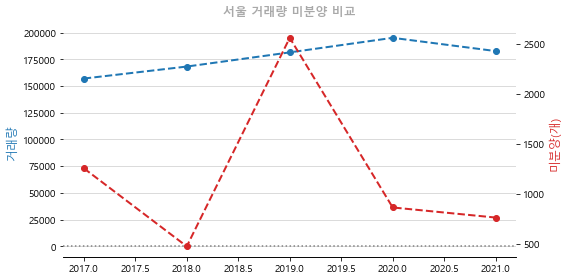

In [3]:
from src.bigquery import bigquery_client, bigquery
from src.sql import DatabaseHandler
from src.openapi import KakaoLocalAPI as kakao
import datetime
bq = bigquery_client

docs = kakao.search_address('잠원동22-10')

# 지번 추출
jibeon = docs['documents'][0]['address_name']

# 시도/ 시군구/ 행정동 코드 추출
sidoCode = docs["documents"][0]["address"]["h_code"][:2]
sigunguCode = docs["documents"][0]["address"]["h_code"][:5]
hdongCode = docs["documents"][0]["address"]["h_code"]

# 행정구역 명칭
sido_ = docs["documents"][0]["address"]["region_1depth_name"]
sigungu_ = docs["documents"][0]["address"]["region_2depth_name"]
if sigungu_ == "":
    sigungu_ = sido_
hdong_ = docs['documents'][0]['address']['region_3depth_h_name']
if hdong_ == "":
    hdong_ = docs['documents'][0]['address']['region_3depth_name']


# 아파트 전세 연도별 거래량
sql = f"""
SELECT contractYear AS year,
       COUNT(*) AS cnt
FROM `aidepartners.aide.transaction_price_apartment_rent`
WHERE pnuCode LIKE '{sidoCode}%'
GROUP BY contractYear
ORDER BY contractYear ASC;
"""
df = bq.query(sql).to_dataframe()
transaction = df.copy()


# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""
SELECT year, 
       SUM(unsold) AS unsold 
FROM aide.unsold_sigungu
WHERE sigunguName !='계'
      AND sidoCode = '{sidoCode}'
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()

# 거래량 데이터와 연도 통일
transaction = transaction.loc[6:,['year','cnt']].reset_index(drop = True)

# Merge
dataset = pd.merge(transaction, unsold,on = 'year', how = 'inner')
dataset = dataset.iloc[:-1]

# Visualization
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(dataset['year'],dataset['cnt'],"o--",label = '거래량',lw=2, color = 'tab:blue')
ax.set_ylabel('거래량', fontsize = 12, color = 'tab:blue')

ax2 = ax.twinx()
ax2.plot(dataset['year'],dataset['unsold'], "o--",label = '미분양',lw=2, color = 'tab:red')
ax2.set_ylabel('미분양(개)', fontsize = 12, color = 'tab:red')

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목 추가
ax.set_title(f"{sido_} 거래량 미분양 비교", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax2.spines[['left','top', 'right']].set_visible(False)


fig.tight_layout()
plt.show()

1. 이론적으로 거래량과 미분양은 상관관계가 별로 없다 라는 가설을 시각화를 통해 확인

2. 2019년 서울시 미분양이 많았는데 왜 그럴까? -> 미분양과 관련있는것 찾아보기

2. 2019년 서울시미분양이 많은 이유탐색

2-1 미분양과 매매가격

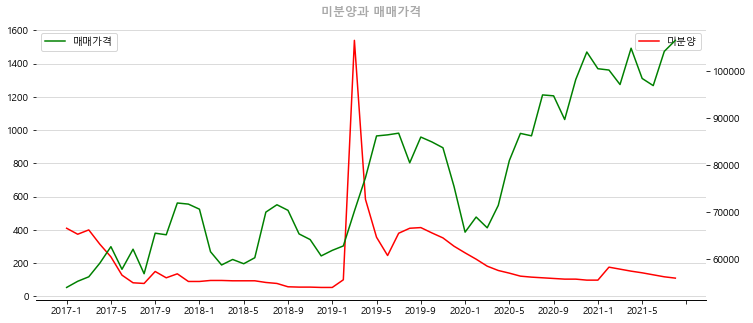

In [69]:
# 미분양과 매매가격
sql = f"""
SELECT year, 
       month, 
       sum(unsold)
FROM aide.unsold_sigungu
WHERE sidoCode = '11'
GROUP BY year, month;
"""
unsold = db.read_table(sql)
unsold = unsold[:-3]
unsold[['year','month']] = unsold[['year','month']].astype('str')
unsold['date'] =  unsold['year']+'-'+unsold['month']
unsold = unsold[:-4]

# 월별로 확인
sql = f"""
SELECT contractYear,
       contractMonth,
       AVG(transactionPrice) AS transactionPrice
FROM `aidepartners.aide.transaction_price_apartment_trading`
WHERE pnuCode LIKE '11%' and contractYear >=2017
GROUP BY contractYear, contractMonth
ORDER BY contractYear, contractMonth;
"""
trading2 = bq.query(sql).to_dataframe()

# 월별확인을 위한 date컬럼생성 및 2022년도 데이터 삭제
trading2[['contractYear','contractMonth']] = trading2[['contractYear','contractMonth']].astype('str')
trading2['date'] = trading2['contractYear'] + '-'+trading2['contractMonth']
trading2 = trading2[:-9]
trading2 = trading2[['date','transactionPrice']]

#시각화
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(unsold['date'], unsold['sum(unsold)'],color = 'red',label = '미분양')
ax2 = ax.twinx()
ax2.plot(trading2['date'], trading2['transactionPrice'],color = 'green',label = '매매가격')

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(20)) 


# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성


# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax2.spines[["left", "top", "right"]].set_visible(False)

# 제목
ax.set_title("미분양과 매매가격", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

ax.legend()
ax2.legend()

큰 상관관계는 없어보인다.

2- 2. 매매가격과의 상관관계 살펴보기

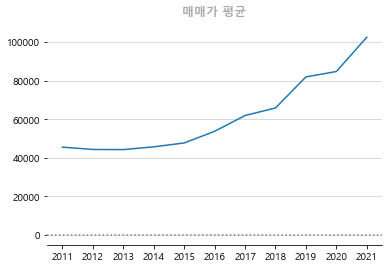

In [4]:
# 매매가의 변동으로 확인해보기
sql = f"""
SELECT contractYear,
       AVG(transactionPrice) AS transactionPrice
FROM `aidepartners.aide.transaction_price_apartment_trading`
WHERE pnuCode LIKE '11%' 
GROUP BY contractYear
ORDER BY contractYear;
"""
trading = bq.query(sql).to_dataframe()
trading = trading.iloc[5:-1]
# 시각화
fig, ax = plt.subplots()
ax.plot(trading['contractYear'],  trading['transactionPrice'])

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목
ax.set_title("매매가 평균", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(12)) 

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)

이렇게 보면 아무것도 일어나지 않은것처럼 보이므로 좀더 세부적으로 접근

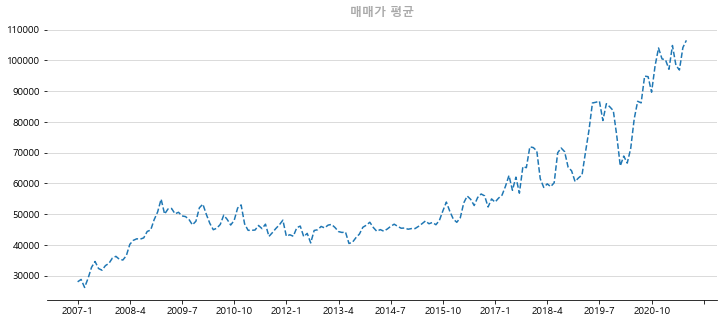

In [71]:
# 월별로 확인
sql = f"""
SELECT contractYear,
       contractMonth,
       AVG(transactionPrice) AS transactionPrice
FROM `aidepartners.aide.transaction_price_apartment_trading`
WHERE pnuCode LIKE '11%' and contractYear >=2007
GROUP BY contractYear, contractMonth
ORDER BY contractYear, contractMonth;
"""
trading2 = bq.query(sql).to_dataframe()

# 월별확인을 위한 date컬럼생성 및 2022년도 데이터 삭제
trading2[['contractYear','contractMonth']] = trading2[['contractYear','contractMonth']].astype('str')
trading2['date'] = trading2['contractYear'] + '-'+trading2['contractMonth']
trading2 = trading2[:-9]

# 시각화
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(trading2['date'],  trading2['transactionPrice'],linestyle='dashed')


# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목
ax.set_title("매매가 평균", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(18)) 

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)

세부적으로 접근하자 2018년말에서 2019년 초 매매가가 하락했던것으로 보인다.. 이때는 서울시의 공급이 많았던 해라고 한다... 그렇다면 얼마나 공급이 매매가격에 영향을주는지 알아보기(수요와 공급의 특성상 영향을 미치는것은 당연하지만 정도의 문제이다.)

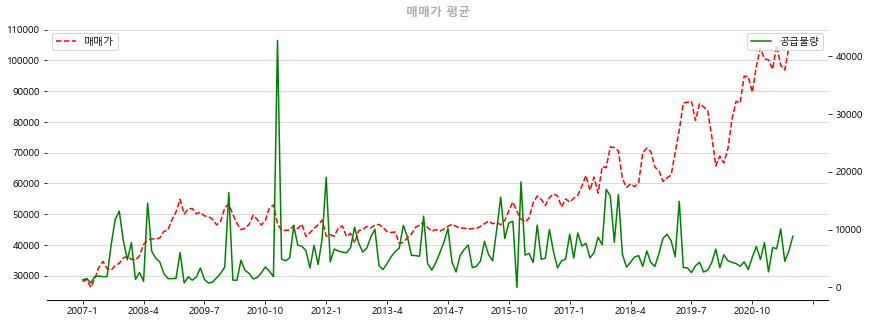

In [72]:
# 공급 + 매매 테이블만들기
permission = pd.read_excel('주택건설인허가실적.xlsx',skiprows = 9)
permission.columns = permission.iloc[0]
permission = permission.iloc[1:]
permission = pd.DataFrame(permission.iloc[1,:]).reset_index().iloc[1:]
permission = permission.rename(columns = {0:'date_f', 2:'supply'})
df = pd.concat([trading2, permission],axis = 1)
df = df[['date', 'transactionPrice','supply']]
df.loc[0,'supply'] = 1300
df = df.iloc[:-1]

# 시각화
fig, ax = plt.subplots(figsize = (14,5))
ax.plot(df['date'],  df['transactionPrice'],linestyle='dashed',color = 'red',label = '매매가')
ax2 =ax.twinx()
ax2.plot(df['date'], df['supply'],color = 'green',label = '공급물량')

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목
ax.set_title("매매가 평균", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# xticks개수 조절
ax.xaxis.set_major_locator(MaxNLocator(18)) 

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax2.spines[["left", "top", "right"]].set_visible(False)
ax.legend()
ax2.legend()

오히려 공급량이 미분양보다 가격에 영향을 조금은 더 주는것같다.

### 2. 미분양과 전세증감률 관계

#### 확인해야할 사항
- 전세증감에서 year별로 그룹핑해서 SUM이 올바른것인가?
- 정규화의 방법

In [ ]:
# 미분양과 전세증감률 관계
from src.openapi import KakaoLocalAPI as kakao
from src.bigquery import bigquery_client, bigquery
from src.sql import DatabaseHandler
import datetime

# DB, Bigquery
bq = bigquery_client
db = DatabaseHandler()

# 카카오 API
docs = kakao.search_address('경기도 수원시 인계동 팔달구1111') # add_list => aide-analysis/src/temp.py 

# 파싱정보 업데이트 
sidoCode = docs["documents"][0]["address"]["h_code"][:2] # 시도 코드
sigunguCode = docs["documents"][0]["address"]["h_code"][:5] # 시군구 코드
sido_ = docs["documents"][0]["address"]["region_1depth_name"] # 시도 명
sigungu_ = docs["documents"][0]["address"]["region_2depth_name"] # 시군구 명
sigungu_ = sigungu_.split(' ')[0]
if sigungu_ == "":
    sigungu_ = sido_

# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""
SELECT unsold_sigungu. year, 
       SUM(unsold_sigungu. unsold) AS unsold 
FROM aide.unsold_sigungu AS unsold_sigungu
INNER JOIN (
            SELECT * 
            FROM aide.mapping_sigungu
           ) AS mapping
      ON unsold_sigungu.sigunguCode = mapping.sigunguCode_B
WHERE mapping.sigunguCode_A = "{sigunguCode}"
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()    



# 전세증감률 연도별 집계테이블 로드
sql = f"""
SELECT T1.year, 
       SUM(T1.jeonseChangeRate) AS jeonseChangeRate
FROM(
        SELECT distinct kb.sigunguCode, mapping.sigunguCode_B, kb.regionName, kb.jeonseChangeRate,  mapping.sidoName, mapping.sigunguName,  YEAR(kb.date) AS year
        FROM aide.kb_weekly_jeonse_change_rate AS kb
        INNER JOIN (SELECT * FROM aide.mapping_sigungu) AS mapping
            ON kb.sigunguCode = mapping.sigunguCode_A
        WHERE sigunguCode LIKE '{sigunguCode[:-1]}%'AND YEAR(date)>=2017
    ) AS T1
WHERE T1.sigunguCode_B = T1.sigunguCode
GROUP BY year
"""
kb = db.read_table(sql)




# Merge( 전세증감 + 미분양)
dataset = pd.merge(kb, unsold, on = 'year', how = 'inner')

# 2021년으로 범위 수정
dataset = dataset.iloc[:-1]

# 시각화
fig, ax = plt.subplots(figsize = (8,4))

# 전세증감율 plot
ax.set_ylabel('전세증감률(%)',fontsize = 12, color = 'tab:blue')
ax.plot(dataset['year'],dataset['jeonseChangeRate'],"o--",label = '전세증감률',lw=2,color = 'tab:blue')

# 미분양 plot
ax2 = ax.twinx()
ax2.set_ylabel('미분양수(개)', fontsize = 12, color = 'tab:red')
ax2.plot(dataset['year'],dataset['unsold'], "o--",label = '미분양',lw=2,color = 'tab:red')



# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목 추가
ax.set_title(f"{sigungu_} 전세증감 미분양 비교", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax2.spines[["left", "top", "right"]].set_visible(False)

# x축 눈금 변환
plt.xticks([2017,2018,2019,2020,2021],[2017,2018,2019,2020,2021])

fig.tight_layout()

plt.show()

#### 한계
**kb데이터는 일부 시군구가 빠져있음. 따라서 시각화가 되지않는 지역이 있음**

In [ ]:
# 거래량 미분양, 전세증감 

from src.openapi import KakaoLocalAPI as kakao
from src.bigquery import bigquery_client, bigquery
from src.sql import DatabaseHandler
import datetime

# DB, Bigquery 헨들러
bq = bigquery_client
db = DatabaseHandler()

# 카카오 API호출
docs = kakao.search_address(add_list[0])


# 파싱정보 업데이트
sidoCode = docs["documents"][0]["address"]["h_code"][:2] # 시도 코드
sigunguCode = docs["documents"][0]["address"]["h_code"][:5] # 시군구 코드
sido_ = docs["documents"][0]["address"]["region_1depth_name"] # 시도 명
sigungu_ = docs["documents"][0]["address"]["region_2depth_name"] # 시군구 명
if sigungu_ == "":
    sigungu_ = sido_ + "(시군구 존재 X)"

#=================================================================================================================
#
#                                                     MAIN CODE
#
#=================================================================================================================


# 아파트 전세 테이블 연도별 거래량
sql = f"""
SELECT contractDate, 
       count(*) AS cnt
FROM `aidepartners.aide.transaction_price_apartment_rent`
WHERE pnuCode LIKE '{sigunguCode}%'
GROUP BY contractDate
ORDER BY contractDate ASC
"""
df = bq.query(sql).to_dataframe()
transaction = df.copy()


# 타입변경
transaction['contractDate'] = pd.to_datetime(transaction['contractDate'],format = '%Y-%m-%d')

# 연도 컬럼 생성
transaction['year'] = transaction['contractDate'].dt.year

# 인덱스 설정
transaction = pd.DataFrame(transaction.groupby('year')['cnt'].sum()).reset_index()
transaction = transaction.iloc[6:]



sql= f"""
SELECT YEAR(date) AS year, SUM(jeonseChangeRate) AS jeonseChangeRate
FROM aide.kb_weekly_jeonse_change_rate
WHERE sigunguCode = {sigunguCode}
GROUP BY YEAR(date) 
order by YEAR(date)
"""
kb = db.read_table(sql)
#kb=kb.iloc[9:]


# 미분양 데이터 로드(연도별 미분양 합)
db = DatabaseHandler()

sql2 = f"""

SELECT year, SUM(unsold) AS unsold 
FROM aide.unsold_sigungu
WHERE sigunguName !='계'
      AND sigunguCode = '{sigunguCode}'
GROUP BY year
ORDER BY year ASC;
"""
df = db.read_table(sql2)
unsold = df.copy()
#unsold['unsold'] = unsold['unsold'].apply(lambda x: round((x/unsold['unsold'].iloc[0])-1,2))

dataset = pd.merge(kb, unsold, on = 'year', how = 'inner')
dataset = pd.merge(dataset, transaction, on = 'year', how = 'inner')
dataset= dataset.iloc[:-1]

# Visualization
fig, ax = plt.subplots(figsize = (8,4))

ax.set_ylabel('전세증감률(%)',fontsize = 12, color = 'tab:blue')
ax.plot(dataset['year'],dataset['jeonseChangeRate'],"o--",label = '전세증감률',lw=2,color = 'tab:blue')


ax2 = ax.twinx()



ax2.set_ylabel('미분양수(개)', fontsize = 12, color = 'tab:red')
ax2.plot(dataset['year'],dataset['unsold'], "o--",label = '미분양',lw=2,color = 'tab:red')

ax3 = ax.twinx()
ax3.set_ylabel('거래량',fontsize = 12, color = 'tab:green')
ax3.plot(dataset['year'],dataset['cnt'],'o--', label = '거래량', lw = 2, color = 'tab:green')

# 세번째 축 위치 조정
ax3.spines["right"].set_position(("axes", 1.2))

# 0점선
ax.axhline(y=0, c="gray", ls=":") 

# 그리드 추가
ax.grid(axis="y", c="lightgray") # "axis = 'x'" 는 x축 세로선 grid생성

# 제목 추가
ax.set_title(f"{sigungu_} 전세증감, 미분양, 거래량 비교", 
             fontweight="bold", fontsize="large", color="darkgray", pad=12)# pad는 타이틀과 그림사이의 거리

# 필요없는 선 제거
ax.spines[["left", "top", "right"]].set_visible(False)
ax2.spines[["left", "top", "right"]].set_visible(False)
ax3.spines[["left", "top", "right"]].set_visible(False)

# x축 눈금 변환
plt.xticks([2017,2018,2019,2020,2021],[2017,2018,2019,2020,2021])

# set figure
fig.tight_layout()
plt.show()

거래량도 전세, 증감도 전세를 기준으로 한 통계

### 3. (미분양과 매매증감률) 

### 4. 매매증감 전세증감 비교

In [ ]:
# sigunguCode parser
sigunguCode = '11110'

# jeonse query parser
sql= f"""
SELECT YEAR(date) AS year, SUM(jeonseChangeRate) AS jeonseChangeRate
FROM aide.kb_weekly_jeonse_change_rate
WHERE sigunguCode = {sigunguCode}
GROUP BY YEAR(date) 
order by YEAR(date)
"""
jeon = db.read_table(sql)

# trading query parser
sql2 = f"""
SELECT YEAR(date) as year, 
       SUM(tradingChangeRate) AS tradingChangeRate
FROM aide.kb_weekly_trading_change_rate
WHERE sigunguCode = {sigunguCode}
GROUP BY YEAR(date)
ORDER BY YEAR(date)
"""
trade = db.read_table(sql2)

In [ ]:
dataset = pd.merge(jeon, trade, on = 'year', how = 'inner')
dataset = dataset.iloc[:-1]

In [ ]:
fig, ax = plt.subplots()
ax.plot(dataset['year'], dataset['tradingChangeRate'], color = 'tab:red', label = '매매증감')
ax.set_ylabel('매매증감', fontsize = 12, color = 'tab:red')
ax2 = ax.twinx()
ax2.plot(dataset['year'], dataset['jeonseChangeRate'], color = 'tab:blue', label = '전세증감')
ax2.set_ylabel('전세증감', fontsize = 12, color = 'tab:blue')
plt.tight_layout()
plt.show()

### 5. 주택인허가 활용(API) -> 3번진행 후 진행

In [ ]:
import sys
path = 'C:\\github\\prop-tech'

sys.path.append(path)

In [ ]:
# 주택인허가 데이터 OPEN API
import requests
import json
import xmltodict
from src.openapi import *

endPoint = "http://apis.data.go.kr/1611000/HsPmsService"
key = housing_permission # api key
operationName = "getHpBasisOulnInfo"
sigunguCode = '11710'
numOfRows = '10'
pageNo = '1'

# 호출 url
url = f"{endPoint}/{operationName}?sigunguCd={sigunguCode}&numOfRows={numOfRows}&pageNo={pageNo}&ServiceKey={key}"
print(url)

# xml to json
result = xmltodict.parse(requests.get(url).text)
result = json.loads(json.dumps(result))
result 

In [ ]:
result['response']['body']['items']['item'][0]

### 전국 주택가격 변화 tracking(plotly)

- 주택가격기준 정하기